### From a high level perspective, the entire pipeline is this

Encode → Split → Preprocess → Tune (via Validation) → Train → Validate → Test


# 1. Encoding


Convert all features to numeric then we get our input data which is X and output label which is Y

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns # for data visualiztions

# Read in dataset 1
df = pd.read_csv("../dataset1_cleaned.csv")


categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

"""
 Machine learning models can only process numerical data.
 
 Categorical columns (like 'Sex', 'ChestPainType', etc.) contain text labels, not numbers.
 
 pd.get_dummies() performs one-hot encoding: it creates new binary columns (0 or 1) for each unique category in those columns.
 
 For example, 'Sex' becomes two columns: 'Sex_Male' and 'Sex_Female',
where each row is marked 1 if that category is active, 0 otherwise.

"""

data = pd.get_dummies(df, columns = categorical_cols)

# HeartDisease is our output label, its 1 if the person had heart disease, 0 if they didntt 

# the whole point is to train a model to accurately predict heartdisease given data in the other columns like chol, BP, sex

# Therefore X is our input features consisting of chol, BP, sex etc ..., so we drop the output column 


X = data.drop("HeartDisease", axis=1)  

# Y is our output feature, so we just extract only the heart disease column 
y = data["HeartDisease"]  


# 2.splitting
We split the dataset into training, validation, and testing sets in a 70/15/15 ratio.

- 70% (training): used by the model to learn patterns from the data
- 15% (validation): used to tune the model and check for overfitting
- 15% (testing): used for the final unbiased evaluation of performance

Each set has both X (features) and y (labels).
You can think of the model like a mathematical function:
it learns to map input X → output y, and the goal is to make this mapping
reliable even for new, unseen X values.


In [2]:

from sklearn.model_selection import train_test_split

# First split: Train (70%) and Temp (30%)

# we're going to take % 30 of the total data to be used for validation and testing and we're going to save it into X_temp and Y_temp 

# X_train and Y_Train are going to be used to train the model because the model learns to pick up how combination of X features form to produce an output in Y


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)

# Second split: Validation (15%) and Test (15%) from Temp

# from our previous split, we got X_temp and Y_temp whjch was 30 % of the original data, 
# now we're going to set test_size = 0.5, so we're going to split it even further into a validation and testing set

# so that means the validation data X_val, Y_val is 15 % of our original data 
# test data X_test, Y_test is 15% of our original data 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0) 

# just a note that random_state = 0 means we're setting a fixed seed so the shuffling of data is reproducible. 

print('Training set shape: ', X_train.shape, y_train.shape)
print('Validation set shape:', X_val.shape, y_val.shape)
print('Testing set shape:   ', X_test.shape, y_test.shape)




Training set shape:  (641, 20) (641,)
Validation set shape: (138, 20) (138,)
Testing set shape:    (138, 20) (138,)


# 3. Preprocessing Overview

Our dataset (`X_train`) includes features like:

`Age`, `Sex`, `ChestPainType`, `RestingBP`, `Cholesterol`, `FastingBS`, etc.

For this dataset, we only have around **11 features**, so feature reduction isn’t critical.
But in larger datasets (e.g. 100+ columns), training can be slow and redundant.
`SelectKBest` solves this by ranking all features based on an F-score (no need to know what an F score is, just that its a rank using a algorithm called ANOVA)

Example:

| Feature     | F-Score | Kept |
| ----------- | ------- | ---- |
| Age         | 142.3   | yes    |
| Cholesterol | 110.8   | yes    |
| FastingBS   | 1.2     | no    |

---

### Standardization

Even though all features are numeric, they’re on different scales:

* **RestingBP:** 80 – 140
* **Cholesterol:** 100 – 400
* **FastingBS:** 0 – 1

Without scaling, high-magnitude features dominate training and bias the model.
`StandardScaler()` rescales each column so it has **mean = 0** and **std = 1**, giving every feature equal weight.

Example:

| Feature   | Before | After |
| --------- | ------ | ----- |
| RestingBP | 140    | +1.2  |
| RestingBP | 80     | −1.4  |

---

**In short:**

* `SelectKBest` → keeps the most informative features
* `StandardScaler` → balances feature scales for fair learning


In [9]:
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest, f_classif
ft = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features
ft.fit(X_train, y_train)

# Transform datasets to keep only selected features
X_train_selected = ft.transform(X_train)
X_val_selected = ft.transform(X_val)
X_test_selected = ft.transform(X_test)

print("Selected Features:", X_train.columns[ft.get_support()])

# -------------------------------
# Preprocessing: Standardization
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected.astype(float))
X_val_scaled = scaler.transform(X_val_selected.astype(float))
X_test_scaled = scaler.transform(X_test_selected.astype(float))

print("Preprocessing complete. Shapes after scaling:")
print("Train:", X_train_scaled.shape, "Validation:", X_val_scaled.shape, "Test:", X_test_scaled.shape)

Selected Features: Index(['Age', 'MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ASY',
       'ChestPainType_ATA', 'ExerciseAngina_N', 'ExerciseAngina_Y',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')
Preprocessing complete. Shapes after scaling:
Train: (641, 10) Validation: (138, 10) Test: (138, 10)


# 4. **hyperparameter tuning**.
A *hyperparameter* is just a value **you**, the user, manually set before training — it’s not part of your `X_train`, so don’t mix them up.

* **Parameter** → features inside your dataset (the ones the model learns from)
* **Hyperparameter** → values you set manually to control how the model learns

---

### 🔹 Why this matters for KNN

KNN’s goal is to classify a point based on the **K nearest neighbours** — but the real question is:
**what’s the right K?**

Think of each row in your dataset as a **point on a graph**.
When you get a new point, the model looks around it and asks:

> “What class are most of my nearby points in?”

If most of your neighbors are labelled “Heart Disease = 1”, then your new point is likely heart disease = true.
If most are “0”, it’s classified as healthy.

---

### 🔹 The K problem

How many neighbours should we look at?

* If **K is too small** → the model becomes *noisy* and overreacts to random points.
* If **K is too large** → the model becomes *blurry* and ignores local detail.

**Analogy:**
Imagine you’re trying to decide if your suburb is high crime or not.

* If you ask the **entire city (huge K)**, you’ll get mixed answers that don’t reflect your area.
* If you ask **only one neighbour (K=1)**, you might draw the wrong conclusion from a single experience.
* The sweet spot is asking a *reasonable number of neighbours* — enough to capture the trend but not drown in noise.

---

### 🔹 Back to the code

That’s exactly what this loop is doing — testing **K from 1 to 20**, quickly training and checking which value gives the best accuracy.
We’re not doing the full training yet — we’re **scouting** for the optimal K before locking in the final model.


In [10]:

#  Hyperparameter tuning PHASE — Find the best K

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np

# We'll store the accuracy for K = 1 → 20
mean_acc = np.zeros(20)

for k in range(1, 21):
    # Train the model using the current K
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = knn.predict(X_test)
    
    # Measure accuracy
    acc = metrics.accuracy_score(y_test, y_pred)
    mean_acc[k - 1] = acc

    print(f"K = {k} → Accuracy: {acc:.4f}")

# Find the best K value
best_k = mean_acc.argmax() + 1
print(f"\n Best K value: {best_k} with Accuracy: {mean_acc[best_k - 1]:.4f}")


k=1, Model: KNeighborsClassifier(n_neighbors=1), Accuracy: 0.5942
k=2, Model: KNeighborsClassifier(n_neighbors=2), Accuracy: 0.6522
k=3, Model: KNeighborsClassifier(n_neighbors=3), Accuracy: 0.6377
k=4, Model: KNeighborsClassifier(n_neighbors=4), Accuracy: 0.6667
k=5, Model: KNeighborsClassifier(), Accuracy: 0.6667
k=6, Model: KNeighborsClassifier(n_neighbors=6), Accuracy: 0.6667
k=7, Model: KNeighborsClassifier(n_neighbors=7), Accuracy: 0.6667
k=8, Model: KNeighborsClassifier(n_neighbors=8), Accuracy: 0.6884
k=9, Model: KNeighborsClassifier(n_neighbors=9), Accuracy: 0.6812
k=10, Model: KNeighborsClassifier(n_neighbors=10), Accuracy: 0.6739
k=11, Model: KNeighborsClassifier(n_neighbors=11), Accuracy: 0.6812
k=12, Model: KNeighborsClassifier(n_neighbors=12), Accuracy: 0.6739
k=13, Model: KNeighborsClassifier(n_neighbors=13), Accuracy: 0.6957
k=14, Model: KNeighborsClassifier(n_neighbors=14), Accuracy: 0.6884
k=15, Model: KNeighborsClassifier(n_neighbors=15), Accuracy: 0.6957
k=16, Model

# 5. Testing and Validation

At this stage, we check how well the model performs on unseen data.
The confusion matrix helps us see where the model predicts correctly and where it makes mistakes.

### Training vs Validation Accuracy

Training accuracy shows how well the model performs on the data it was trained with.
Validation (or test) accuracy shows how well the model performs on new, unseen data.

If training accuracy is much higher than validation accuracy, the model is likely overfitting — it memorizes the training data instead of learning general patterns.
If both are close, it means the model generalizes well and is likely balanced.

In [15]:
# TRAINING 

# Train the final model using the best K
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train, y_train)

# Make predictions on both train and test data
y_train_pred = final_knn.predict(X_train)
y_test_pred = final_knn.predict(X_test)

# VALIDATION 

# Evaluate accuracy
train_acc = metrics.accuracy_score(y_train, y_train_pred)
test_acc = metrics.accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation (Test) Accuracy: {test_acc:.4f}")

# Detailed performance metrics
from sklearn.metrics import confusion_matrix, classification_report
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Training Accuracy: 0.7410
Validation (Test) Accuracy: 0.6957

Confusion Matrix:
 [[40 23]
 [19 56]]

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.63      0.66        63
           1       0.71      0.75      0.73        75

    accuracy                           0.70       138
   macro avg       0.69      0.69      0.69       138
weighted avg       0.69      0.70      0.69       138



### Model Results Interpretation

**Training Accuracy:** 0.74
**Validation (Test) Accuracy:** 0.70

The model performs slightly better on the training data than on new test data.
This means it has learned useful patterns and is not heavily overfitting.

**Confusion Matrix:**

```
[[40 23]
 [19 56]]
```

* 40 true negatives (correctly predicted no heart disease)
* 56 true positives (correctly predicted heart disease)
* 23 false positives (predicted heart disease when there was none)
* 19 false negatives (missed actual heart disease cases)

**Classification Report Summary**

* **Precision:** 0.71 → when the model predicts heart disease, it is right about 71% of the time.
* **Recall:** 0.75 → it correctly finds about 75% of all real heart disease cases.
* **F1-score:** 0.73 → overall balance between precision and recall.
* **Accuracy:** 0.70 → 70% of predictions are correct overall.

**Overall Interpretation:**
The KNN model performs reasonably well. It generalizes fairly to new data, catches most heart disease cases, and maintains a balanced trade-off between accuracy and reliability. It could still be improved with more data or feature tuning, but it is a solid baseline result.


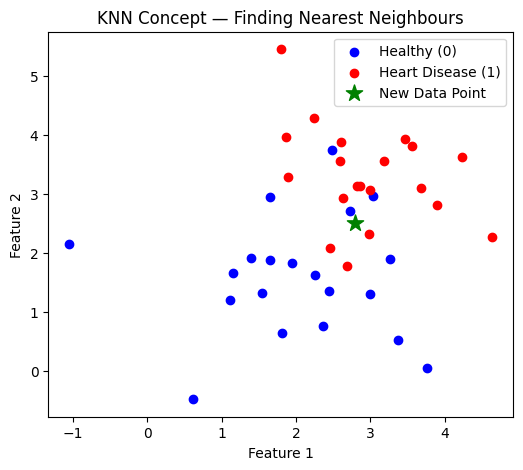

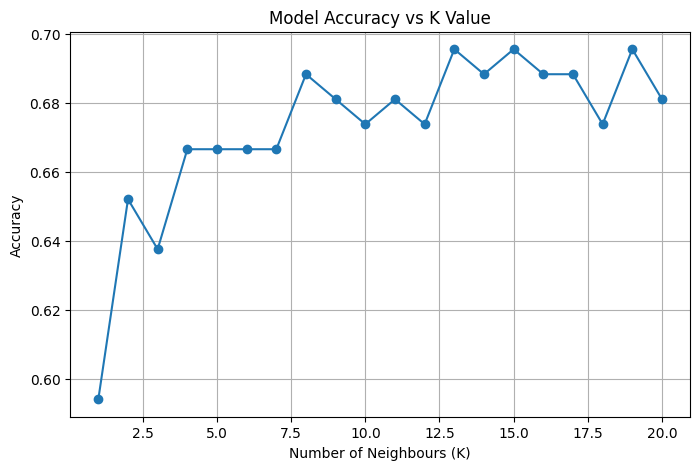

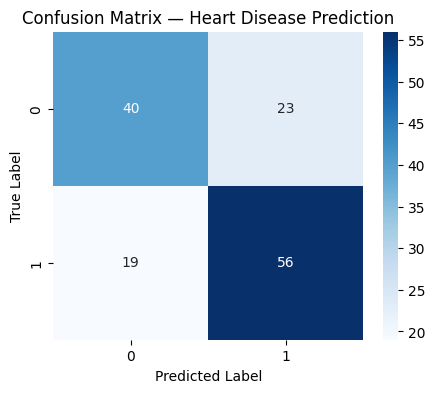

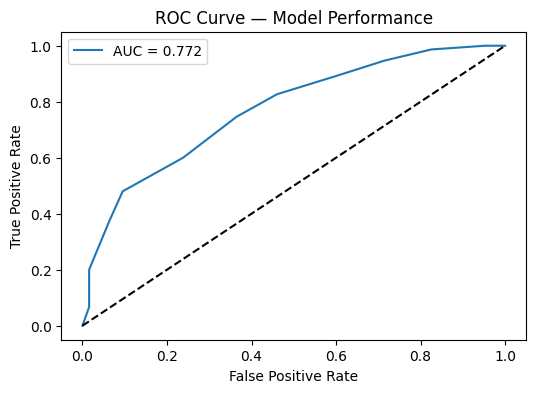

In [16]:

# End of main pipeline, here are some great supporting diagrams 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# ---------------------------
# 1. KNN Concept Diagram
# ---------------------------
np.random.seed(0)
X0 = np.random.randn(20, 2) + 1.5  # Class 0 (Healthy)
X1 = np.random.randn(20, 2) + 3.5  # Class 1 (Heart Disease)
new_point = np.array([[2.8, 2.5]])

plt.figure(figsize=(6, 5))
plt.scatter(X0[:,0], X0[:,1], color='blue', label='Healthy (0)')
plt.scatter(X1[:,0], X1[:,1], color='red', label='Heart Disease (1)')
plt.scatter(new_point[:,0], new_point[:,1], color='green', s=150, marker='*', label='New Data Point')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("KNN Concept — Finding Nearest Neighbours")
plt.legend()
# plt.savefig("knn_concept.png", dpi=300)
plt.show()


# ---------------------------
# 2. Accuracy vs K Plot
# ---------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), mean_acc, marker='o')
plt.title("Model Accuracy vs K Value")
plt.xlabel("Number of Neighbours (K)")
plt.ylabel("Accuracy")
plt.grid(True)
# plt.savefig("accuracy_vs_k.png", dpi=300)
plt.show()


# ---------------------------
# 3. Confusion Matrix Heatmap
# ---------------------------
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Heart Disease Prediction")
# plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


# ---------------------------
# 4. ROC Curve (Optional)
# ---------------------------
try:
    y_prob = final_knn.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')  # baseline
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — Model Performance")
    plt.legend()
    # plt.savefig("roc_curve.png", dpi=300)
    plt.show()
except:
    print("ROC curve unavailable (model may not support predict_proba).")

# ---------------------------
# End of Supporting Diagrams
# ---------------------------


### 🔹 Extension Commentary

Originally, this was your code for training. I get that it might’ve been pulled from Kaggle or AI-generated, but honestly — this is **overkill** for our scope.

Remember: in hyperparameter tuning, we already selected the best **K value** by iterating through possible values manually.

Here, **GridSearchCV** does the same thing — but on steroids.
It takes a **list of potential hyperparameters**, not just for **K**, but also for **weights** and **metric**, and tests **every combination** to find the best one.

If our goal is pure accuracy, then yes — this is technically better than our earlier tuning loop because it explores multiple hyperparameter combinations at once.
But only include this if you actually understand how each of those parameters changes the model’s behavior.

---

### 🔹 Breakdown of Parameters

* **`n_neighbors`** → The number of neighbours (K) to consider. Simple.

* **`metric`** → How “distance” between points is measured.
  To find our nearest neighbours, we need a rule for what *close* means.
  Common options:

  * **Euclidean:** straight-line distance —
    (\sqrt{(x₁−x₂)² + (y₁−y₂)² + …})
  * **Manhattan:** grid-style distance — imagine walking around buildings in a city block.
  * **Minkowski:** a general formula that can act as both Euclidean and Manhattan, depending on its parameter (p).

* **`weights`** → How much influence each neighbour has.
  Using the **high-crime suburb analogy**:

  * **Uniform:** every neighbour’s opinion counts equally.
  * **Distance:** closer neighbours matter more — we trust people living nearer to us.

---

### 🔹 Final Note

If you’re going to include `GridSearchCV`, the **previous manual tuning step becomes redundant**, because GridSearch already automates that entire process — and more.
Just make sure you can **explain each hyperparameter** if you choose to show it.


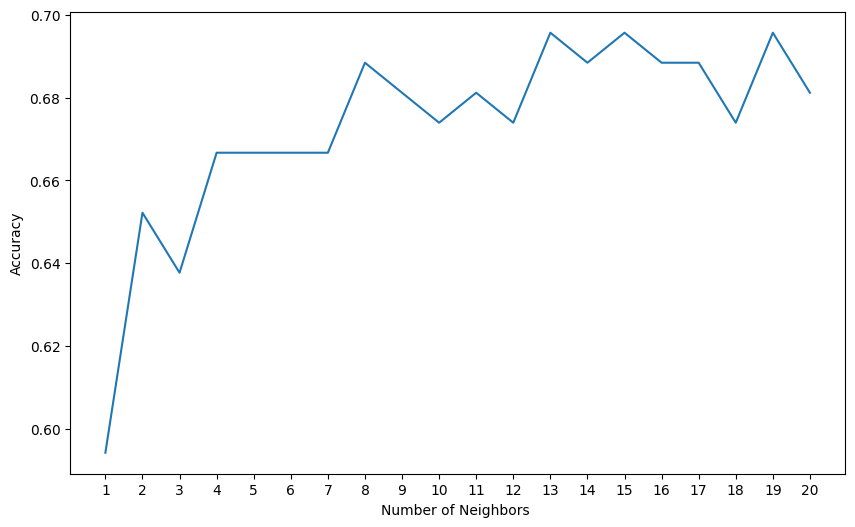

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Score: 0.7285
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
Training set accuracy:  1.0
Test set accuracy:  0.7463768115942029
[[42 21]
 [14 61]]
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        63
           1       0.74      0.81      0.78        75

    accuracy                           0.75       138
   macro avg       0.75      0.74      0.74       138
weighted avg       0.75      0.75      0.74       138

Model accuracy:  0.7262948443810882
Precision: 0.7439
Recall: 0.8133
F1-score: 0.7771


In [14]:

loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,21), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

from sklearn.model_selection import GridSearchCV

grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)
g_res = gs.fit(X_train, y_train)

print(f"Best Score: {g_res.best_score_:.4f}")
print(f"Best Parameters: {g_res.best_params_}")

knn = KNeighborsClassifier(n_neighbors = 15, weights = 'distance', algorithm = 'brute',metric = 'manhattan')
knn.fit(X_train, y_train)

y_hat = knn.predict(X_train)
y_knn = knn.predict(X_test)

print('Training set accuracy: ', metrics.accuracy_score(y_train, y_hat))
print('Test set accuracy: ',metrics.accuracy_score(y_test, y_knn))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_knn))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_knn))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, X, y, cv =5)

print('Model accuracy: ',np.mean(scores))

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_knn)
recall = recall_score(y_test, y_knn)
f1 = f1_score(y_test, y_knn)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

### Extended Model Results (Grid Search)

After using GridSearchCV to explore multiple hyperparameter combinations (for *K*, distance metric, and weighting), the best setup was:
**`metric = 'manhattan'`, `n_neighbors = 15`, `weights = 'distance'`.**

**Training Accuracy:** 1.00
**Test Accuracy:** 0.75

The model performs well on training data but maintains a similar level of test accuracy to the simpler version (~70–75%).
This shows that while extra hyperparameter tuning improves optimization slightly, **KNN’s effectiveness on this dataset is limited**, likely because the relationships between features and heart disease are more complex than what KNN can capture.
